# Assignment Sheet 2

## Assignment 2.1

What filter techniques from the feature selection framework can be applied for a text classification task? What filters are not, or at least less, suitable for text? Justify your answer under a careful reconsideration of the nature of the features in use! For simplicity just assume a Bag-Of-Words representation of the text.

In the BOW framework, each word is a separate feature with a numerical value representing how many times it was recorded in each document. The first step is selecting which filter method is best for feature selection in this context is to consider the distribution of the words - it is unlikely the words will follow a normal distribution (exponential is more likely). Therefore, simple parametric filters like ANOVA and t-test are not suitable.

Mutual information filtering can be used as it quantifies the amount of information shared between a class label and a feature. This is a useful method in our case. Similarly, the chi-square test is useful as it can compare observed vs expected values and determine whether certain words appear more often than we would expect it by chance in each class. The most informative words should be retained (features selected) and the others potentially disregarded (features to be ignored).

## Assignment 2.2

Implement suitable filters (or use methods from Python Sk-learn or similar tool-kits) for a classification task of your own choice! Report performance measures (you can consider a benchmark dataset like 20 Newsgroups) of your classifiers in respect to the filtered features, e.g. on a regular grid (50, 100, 150, 200, 250, ...) of feature set sizes. Provide plots where ever possible to explain your answer.

0.7110993096123208
0.6999468932554435
0.6818906001062135
0.6509559214020181
0.6319702602230484
0.6007700477960701
0.536510886882634
0.4642857142857143


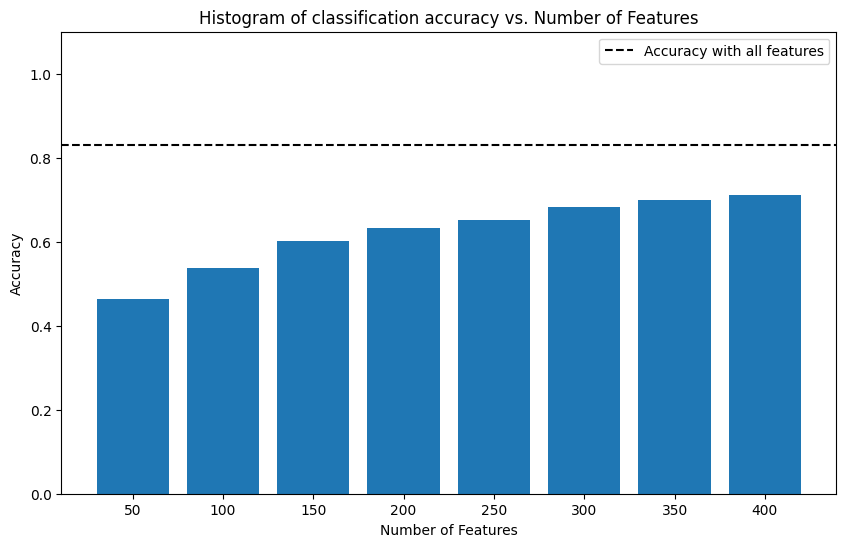

In [12]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.naive_bayes import ComplementNB
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import vstack


def load_dataset():
    """Load and vectorise the 20 newsgroups dataset."""
    data_train = fetch_20newsgroups(subset="train", random_state=42)
    data_test = fetch_20newsgroups(subset="test", random_state=42)

    target_names = data_train.target_names
    y_train, y_test = data_train.target, data_test.target

    vectoriser = TfidfVectorizer(stop_words="english")
    X_train = vectoriser.fit_transform(data_train.data)
    X_test = vectoriser.transform(data_test.data)
    feature_names = vectoriser.get_feature_names_out()

    return X_train, X_test, y_train, y_test, feature_names, target_names

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score


# Load data with all class labels, perform train/test split 
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset()

# We will need this for the feature reduction 
X_combined = vstack([X_train, X_test])
y_combined = np.hstack([y_train, y_test])

# First, determine the classification accuracy without removing any features 
clf_all_f = ComplementNB(alpha=0.1) # Initiate the classifier 
clf_all_f.fit(X_train, y_train) # Train on all data
best_accuracy = clf_all_f.score(X_test, y_test) # Obtain classification accuracy score 

# Feature selection and classification. For the filter, we are going to use the chi-squared test. 
# This is fair since the sample sizes are quite large 
score_list = []
features_n = [400, 350, 300, 250, 200, 150, 100, 50]
for features in features_n:
    X_new = SelectKBest(chi2, k=features).fit_transform(X_combined, y_combined)
    clf = ComplementNB(alpha=0.1)
    clf.fit(X_new[:len(y_train)], y_train)  # Train on the original training data
    pred = clf.predict(X_new[len(y_train):])  # Test on the original test data
    score = metrics.accuracy_score(y_test, pred)
    score_list.append(score)
    print(score)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(features_n, score_list, width=40,)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Histogram of classification accuracy vs. Number of retained features')
plt.grid(False)
plt.axhline(y=best_accuracy, color='black', linestyle='--', label='Accuracy with all features')
plt.legend()
plt.ylim([0, 1.1])
plt.show()


I have used the chi-square test to retain $n$ features and perform classification of the 20newsgroup dataset with a Naive Bayes. The classification accuracy is still very high even if we remove the vast majority of features.

## Assignment 2.3

Does the proposed feature scaling affect every Machine-Learning model? If not, which models are affected and which models are not? Justify your answer in respect to the parametrization of your chosen models! (Gaussian-Naive-Bayes, Logistic-Regression and non-linear Support-Vector-Machine models might be good candidates for your reasoning.)

Feature scaling refers to normalising features used in the data in ML tasks. For example, weight and height might have very different values and one way to make them comparable is to use the z-score. This approach is called standardisation. Another way to approaching this is to normalise by the largest value, such that the input values end up being between 0 and 1 which may be necessary for certain algorithms / models.

The Naive Bayes algorithm does not take into account the magnitude of the features but rather the class probabilities and therefore it is not affected by feature scaling not is that necessary.

Logistic Regression does take into account the magnitude and therefore feature scaling is recommended.

SVMs, using non-linear kernels, take into account distances between data points. SVM, just like KNN and K-means are based on distances between instances and therefore feature scaling strongly affects these algorithms.


## Assignment 2.4

Use an iteratively trained classifier on a classification task of your own choice (you can consider a benchmark dataset like 20 Newsgroups and a tool-kit of your choice). Compare its convergence when trained on the original feature and on scaled features. Provide plots where ever possible to explain your answer. What do you observe and how can this phenomenon be explained?

train time original: 0.0392s
train time normalised: 0.00305s


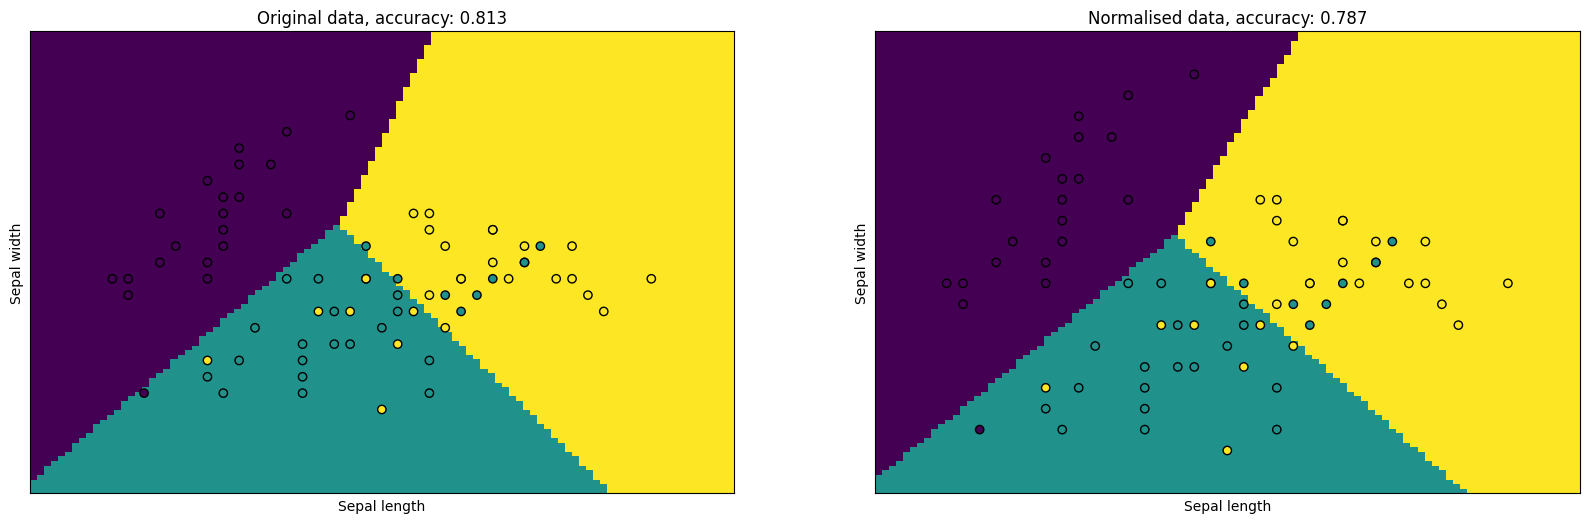

In [2]:
# Attempt to classify the flowers with and without feature scaling

from sklearn import datasets
import matplotlib.pyplot as plt
from time import time
from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Select only the first two features
X_subset = X[:, :2]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.5, random_state=42)

# Initialize Logistic Regression models, one for original and one for normalised data
logreg_original = LogisticRegression(max_iter=1000, random_state=42)
logreg_normalized = LogisticRegression(max_iter=1000, random_state=42)

# Create normalised versions of the features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Train the models differentially on original and normalised data
t0 = time()
logreg_original.fit(X_train, y_train)
train_time = time() - t0
print(f"train time original: {train_time:.3}s")

t0 = time()
logreg_normalized.fit(X_train_normalized, y_train)
train_time = time() - t0
print(f"train time normalised: {train_time:.3}s")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
DecisionBoundaryDisplay.from_estimator(
    logreg_original,
    X_train,
    # cmap=plt.cm.Paired,
    ax=axs[0],
    response_method="predict",
    plot_method="pcolormesh",
    # shading="auto",
    xlabel="Sepal length",
    ylabel="Sepal width",
    eps=0.5,
)

DecisionBoundaryDisplay.from_estimator(
    logreg_normalized,
    X_train_normalized,
    # cmap=plt.cm.Paired,
    ax=axs[1],
    response_method="predict",
    plot_method="pcolormesh",
    # shading="auto",
    xlabel="Sepal length",
    ylabel="Sepal width",
    eps=0.5,
)

# Plot also the training points
axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="k")
axs[1].scatter(X_train_normalized[:, 0], X_train_normalized[:, 1], c=y_train, edgecolors="k")

axs[0].set_xticks(())
axs[0].set_yticks(())

axs[1].set_xticks(())
axs[1].set_yticks(())

score_org = logreg_original.score(X_test, y_test)
score_log = logreg_normalized.score(X_test_normalized, y_test)

axs[0].set_title(f"Original data, accuracy: {score_org:.3f}")
axs[1].set_title(f"Normalised data, accuracy: {score_log:.3f}")

plt.show()